In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
T90=np.array(data[6],dtype=float)
time_err=np.array(data[7],dtype=float)
Flux=np.array(data[9],dtype=float)
redshift=np.array(data[11],dtype=float)
T100=np.array(data[12],dtype=float)


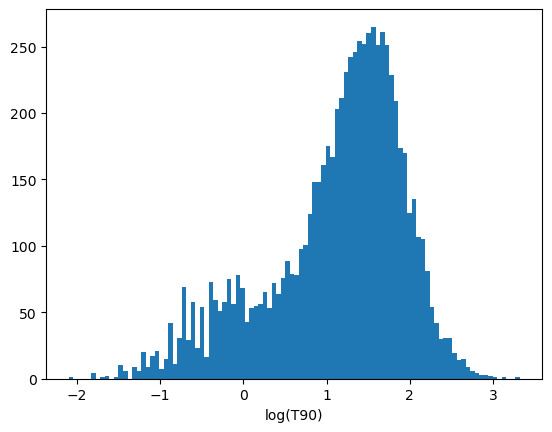

In [5]:
mask= (T90 != -999) & (~np.isnan(T90))
T90_pulito=T90[mask]
#plt.hist(T90, bins=100)
#plt.show()
plt.hist(np.log10(T90_pulito), bins=100)
plt.xlabel("log(T90)")
plt.show()

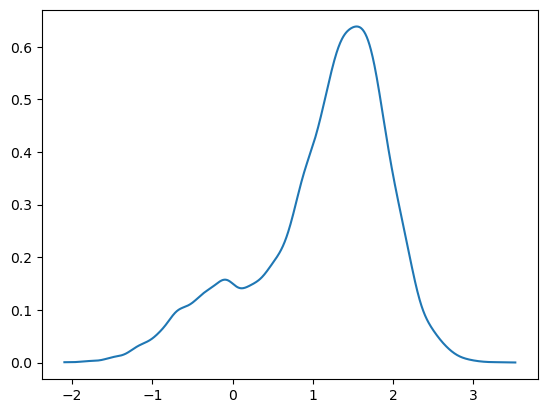

In [6]:
xgrid=np.linspace(min(np.log10(T90_pulito)), max(np.log10(T90_pulito))+0.2, 1000)

kde=KernelDensity(kernel='gaussian', bandwidth=0.1)
kde.fit(np.log10(T90_pulito)[:,np.newaxis])
pdf = np.exp(kde.score_samples((xgrid)[:,np.newaxis]))

plt.plot(xgrid, pdf);

In [7]:
#scelgo bandwidth ottimale con cross validation

bwrange = np.linspace(0.01,1.0, 40) 
K = 5 
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) 
grid.fit(np.log10(T90_pulito)[:, np.newaxis]) 
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.11153846153846153


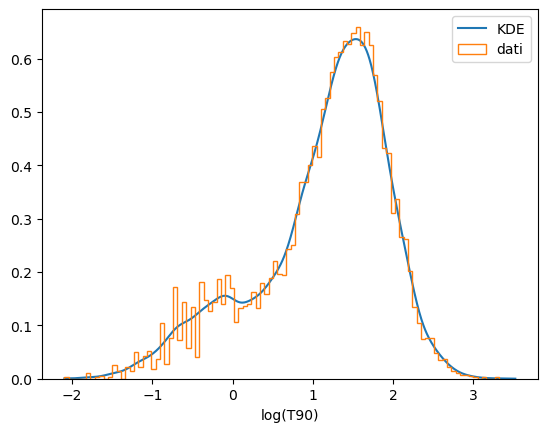

In [8]:

plt.hist(np.log10(T90_pulito), histtype='step', bins=100, label="dati", density=True)
plt.legend()
plt.xlabel("log(T90)")
plt.show()

In [14]:
#cerco i cluster
X_time=np.log10(T90_pulito)[:, np.newaxis]
clf = KMeans(n_clusters=2, n_init='auto') 
clf.fit(X_time)
centers_time = clf.cluster_centers_  
centers_time = np.sort(centers_time.reshape(1, 2))
labels_time = clf.predict(X_time)   
print("centri dei clusters: ", centers_time)

centri dei clusters:  [[-0.04241508  1.52229989]]


confine:  0.6126546408629314


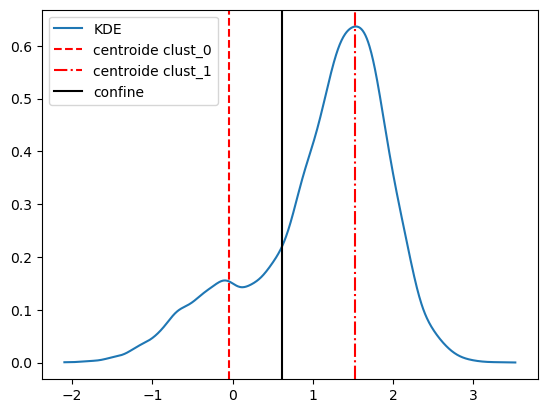

posizione dei picchi [[ 0.90695329 33.28893417]] sec


In [22]:
cluster_0 = X_time[labels_time == 0]
cluster_1 = X_time[labels_time == 1]

limite= np.mean( [max(cluster_0), min(cluster_1)] )
print("confine: ", limite)

plt.plot(xgrid, pdf_ottimale, label="KDE")
plt.axvline(x=centers_time[:, 0], color='r', linestyle='--',label="centroide clust_0")
plt.axvline(x=centers_time[:, 1], color='r', linestyle='-.', label="centroide clust_1")
plt.axvline(x=limite, color='black', linestyle='-', label= "confine")
plt.legend()
plt.show()
print("posizione dei picchi",10**centers_time, "sec")

In [56]:
#valuto quanto è buono il modello di kmeans

silhouette_avg = silhouette_score(X_time, labels_time)  #Misura quanto un punto è simile ai punti del proprio cluster rispetto 
                                                        #ai punti di altri cluster, il valore varia tra -1 e 1, dove un valore 
                                                        #vicino a 1 indica che i punti sono ben raggruppati.
davies_bouldin = davies_bouldin_score(X_time, labels_time) #È la media del rapporto tra la somma delle dispersioni intra-cluster
                                                           #e la distanza tra i cluster. Un valore più basso indica una migliore 
                                                           #separazione dei cluster.
        

print("silhoutte: ", silhouette_avg)
print("davies: ", davies_bouldin)

#dal valore di silhoutte si deduce che i cluster sono ben separati, quando è vicino a 0 significa che punti sono molto vicini 
#al bordo tra i cluster, quando è negativo significa che i punti potrebbero essere stati assegnati al cluster sbagliato.
#il valore di davies è una stima sulla separazione tra i cluster, più basso è più significa che i cluster sono ben separati.

silhoutte:  0.6403502201901142
davies:  0.5118601138062464


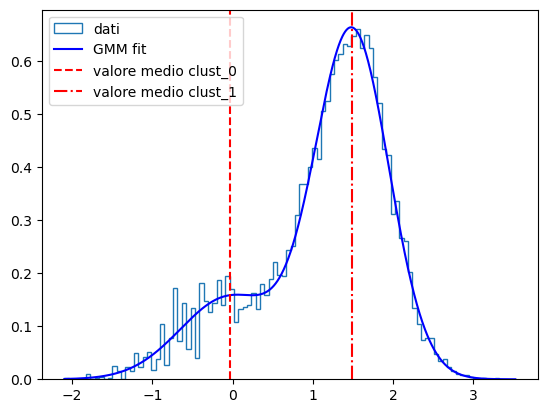

means of gaussians: [-0.03240754  1.48670733]
centri dei clusters:  -0.04241508047823772 1.5222998903598652
differenza centri clust_0: 0.0136426836711174
differenza centri clust_1: 0.04852122565903932


In [24]:
from sklearn.mixture import GaussianMixture

gm=GaussianMixture(n_components=2, random_state=0)
fit=gm.fit(X_time)
means=(gm.means_).flatten()
means=np.sort(means)

xgrid=xgrid.reshape(-1,1)
plt.hist(np.log10(T90_pulito), histtype='step', bins=100, label="dati", density=True)
plt.plot(xgrid, np.exp(gm.score_samples(xgrid)), color='blue', label="GMM fit")
plt.axvline(x=means[0], color='r', linestyle='--',label="valore medio clust_0")
plt.axvline(x=means[1], color='r', linestyle='-.', label="valore medio clust_1")
plt.legend()
plt.show()

centri=centers_time.reshape(-1)
means=means.reshape(-1)
print("means of gaussians:", means)
print("centri dei clusters: ",centri[0], centri[1])
print("differenza centri clust_0:", np.abs(means[0]-centri[0])/np.mean([means, centri]))
print("differenza centri clust_1:", np.abs(means[1]-centri[1])/np.mean([means, centri]))

#ottengo stessi valori con gmm e con kmeans

0.11851518609550563


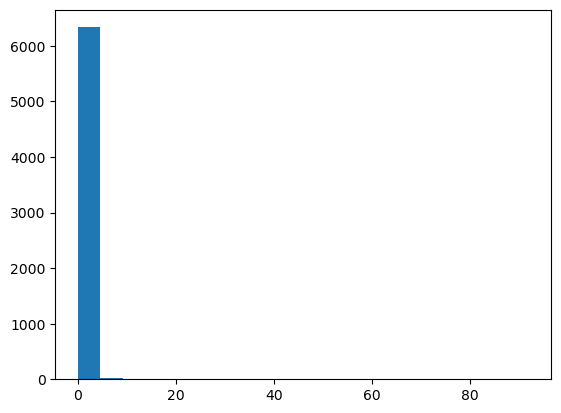

In [26]:
T90=np.array(data[6],dtype=float)
time_err=np.array(data[7],dtype=float)

mask= (T90 != -999) & (~np.isnan(T90)) & (time_err != -999) & (~np.isnan(time_err))
time_err=time_err[mask]
T90=T90[mask]

err_relativo=time_err/T90
plt.hist(err_relativo, bins=20);
print(np.median(err_relativo)) 
#è dell'ordine della bandwitdh e quindi posso trascurare gli errori

In [28]:
#dimensionality reduction

T90=np.array(data[6],dtype=float)
dati=np.column_stack((T90, Flux, T100))
#redshift ha molti valori nulli o non validi, se lo tengo in considerazione dopo aver standardizzato i punti ne rimangono 500 

In [29]:
dati.shape

(8480, 3)

In [30]:
rows_with_nan_or_999 = np.any(np.isnan(dati) | (dati == -999), axis=1)

dati_puliti = dati[~rows_with_nan_or_999]

In [31]:
dati_puliti.shape

(7324, 3)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dati_stand = scaler.fit_transform(dati_puliti)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1) 
pca.fit(dati_stand) 

reduced = pca.transform(dati_stand)
evals = pca.explained_variance_ratio_
print(evals)
#perdo troppa informazione

[0.65306947]


In [36]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, max_iter=100)
#ridurre a 1 dimensione aveva un errore troppo grande

nmf.fit(dati_puliti) 

W = nmf.transform(dati_puliti) 

err = nmf.reconstruction_err_ 

print(W.shape)
print(err)

(7324, 2)
18.996578290666594


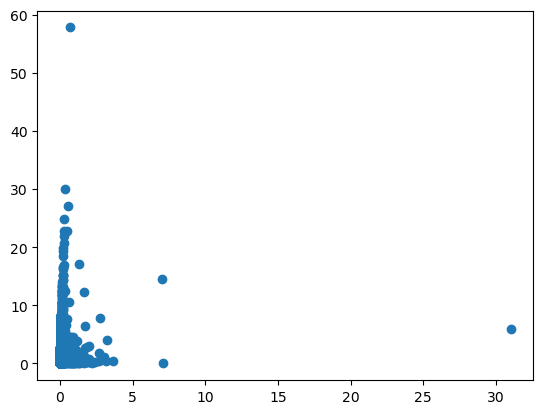

In [39]:
plt.scatter(W[:,0], W[:, 1]);
#anche facendo il logaritmo non si distinguono dei cluster

In [62]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=1) 
ica.fit(dati_stand)

proj = ica.transform(dati_stand) 

C:\Users\leoni\AppData\Local\Temp\ipykernel_16024\3326207954.py:1: RuntimeWarning: invalid value encountered in log10
  logproj=np.log10(proj)


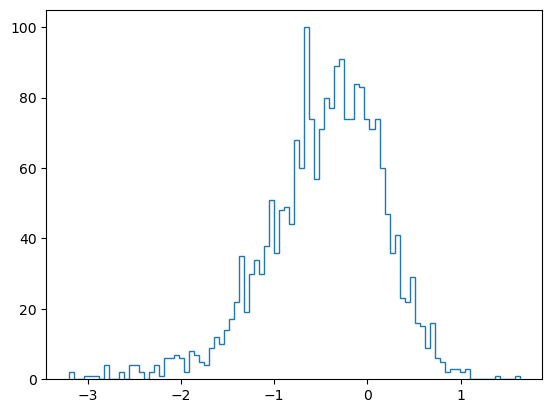

In [63]:
logproj=np.log10(proj)
mask= (~np.isnan(logproj))
logproj=logproj[mask]

plt.hist((logproj), histtype='step', bins=90);


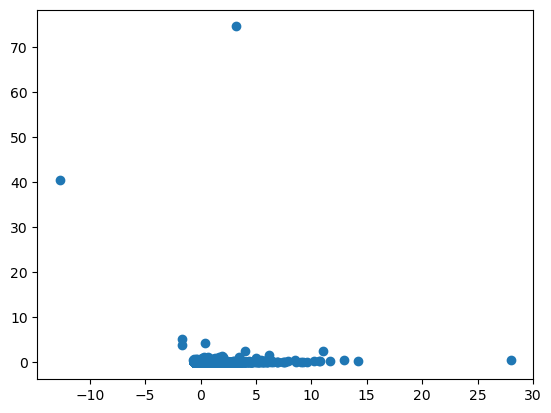

In [64]:
ica = FastICA(n_components=2) 
ica.fit(dati_stand)

proj = ica.transform(dati_stand)
plt.scatter(proj[:,0], proj[:, 1]);

In [108]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=9, n_components=1)  
lle.fit(dati_stand)
proj = lle.transform(dati_stand)

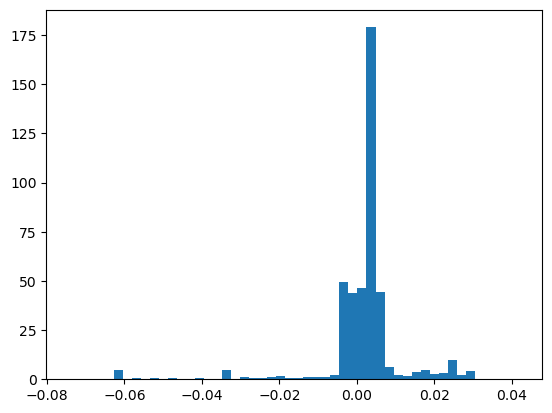

In [109]:
plt.hist(proj, bins=50, density=True);

In [110]:
lle = LocallyLinearEmbedding(n_neighbors=9, 
                             n_components=2)
lle.fit(dati_stand)
proj2 = lle.transform(dati_stand)

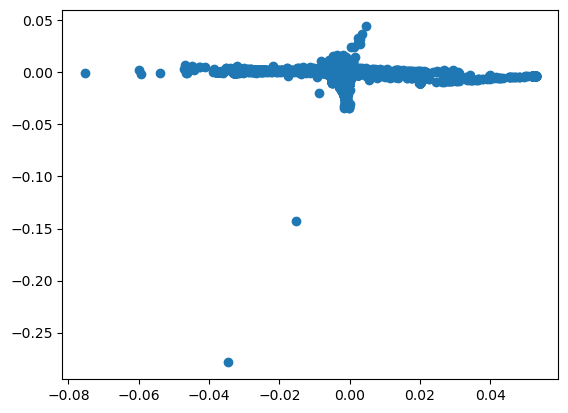

In [111]:
plt.scatter(proj2[:, 0], proj2[:, 1]);

In [112]:
from sklearn.manifold import Isomap

k = 10 
n = 1 
iso = Isomap(n_neighbors=k, n_components=n)
iso.fit(dati_stand)
proj = iso.transform(dati_stand) 

C:\Users\leoni\AppData\Local\Temp\ipykernel_16024\804310684.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(proj), bins=20);


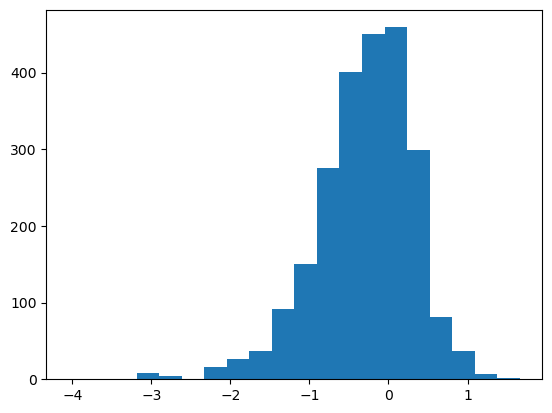

In [113]:
plt.hist(np.log10(proj), bins=20);

In [71]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=1,learning_rate=200)
X_reduced = tsne.fit_transform(dati_stand)

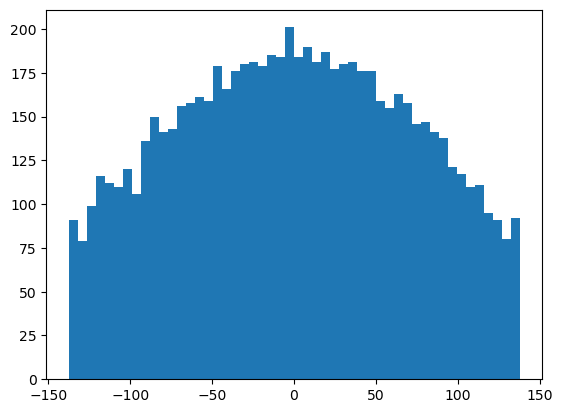

In [82]:
plt.hist(X_reduced, bins=50);

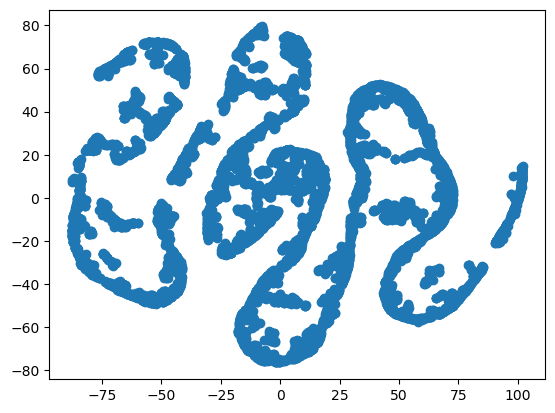

In [73]:
tsne = TSNE(n_components=2,learning_rate=200)
X_reduced = tsne.fit_transform(dati_stand)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1]);